In [22]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin

In [2]:
hrv = pd.read_excel('../Tables/hrv_physiotools.xlsx', index_col = 0)

In [3]:
hrv

,participant,session,odeur,bloc,trial,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD
0,P01,ses02,odor_-,Free,1,798.832877,95.418341,798.0,37.065055,0.119447,0.046447,-0.832877,123.136478
0,P01,ses02,odor_-,Free,2,896.122581,260.360998,819.0,32.617249,0.290542,0.039826,-77.122581,302.982023
0,P01,ses02,odor_-,Slow,1,815.000000,154.922028,798.0,48.925873,0.190088,0.061311,-17.000000,210.236286
0,P01,ses02,odor_-,Slow,2,764.666667,164.313048,748.5,106.747360,0.214882,0.142615,-16.166667,185.132771
0,P01,ses02,odor_-,Slow,3,931.964286,311.213693,826.5,31.134647,0.333933,0.037670,-105.464286,346.249799
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,P28,ses04,odor_-,Comfort,2,841.907767,53.917199,840.0,61.527992,0.064042,0.073248,-1.907767,43.203803
0,P28,ses04,odor_-,Comfort,3,871.111702,94.407183,864.5,83.767025,0.108376,0.096897,-6.611702,114.474475
0,P28,ses04,odor_-,Fast,1,796.560538,36.265150,798.0,29.652044,0.045527,0.037158,1.439462,28.817459
0,P28,ses04,odor_-,Fast,2,893.276042,126.138077,883.5,59.304089,0.141208,0.067124,-9.776042,153.711230


In [16]:
hrv.groupby('participant').mean().sort_values(by = 'HRV_Asymmetry')

/tmp/ipykernel_274495/3887514319.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv.groupby('participant').mean().sort_values(by = 'HRV_Asymmetry')


,trial,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD
participant,,,,,,,,,
P01,1.909091,972.203835,211.704474,916.296875,90.809386,0.219349,0.090457,-55.906960,312.143506
P14,1.909091,836.541616,118.696269,811.954545,104.298820,0.136926,0.125589,-24.587071,124.108810
P19,1.909091,833.783005,127.447752,816.060606,118.046586,0.151152,0.139145,-17.722399,137.300622
P10,1.909091,850.697691,115.673941,833.409091,92.190902,0.134494,0.109674,-17.288600,115.501203
P23,1.909091,839.366538,90.940713,822.878788,70.648242,0.107572,0.085426,-16.487750,66.834364
P24,1.909091,805.635377,114.913550,789.575758,93.022057,0.141599,0.117512,-16.059619,111.341862
P27,1.909091,754.772665,85.129559,739.666667,78.825018,0.112112,0.106579,-15.105998,71.175305
P17,1.909091,878.210129,117.378592,864.000000,81.453267,0.132765,0.094034,-14.210129,140.613077
P06,1.909091,855.528665,106.788395,847.621212,64.223632,0.124592,0.076314,-7.907453,123.017832


/tmp/ipykernel_274495/2278669669.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hrv.corr(), annot = True, cmap = 'seismic', center = 0)


<AxesSubplot: >

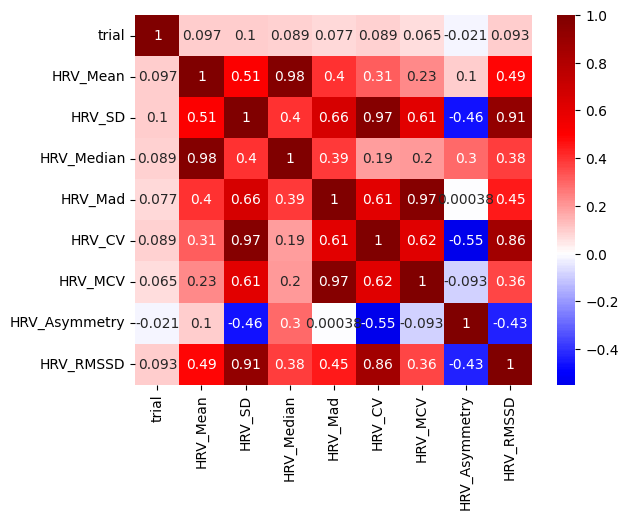

In [21]:
sns.heatmap(hrv.corr(), annot = True, cmap = 'seismic', center = 0)

In [18]:
hrv.groupby('participant').mean()

/tmp/ipykernel_274495/98060372.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv.groupby('participant').mean()


,trial,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD
participant,,,,,,,,,
P01,1.909091,972.203835,211.704474,916.296875,90.809386,0.219349,0.090457,-55.906960,312.143506
P03,1.909091,1121.001030,163.555545,1132.712121,131.210296,0.146821,0.117955,11.711091,191.194954
P04,1.909091,823.947233,86.736359,819.560606,83.474998,0.104865,0.101139,-4.386627,74.739903
P05,1.909091,724.013104,40.907955,720.893939,40.749097,0.056208,0.056201,-3.119165,26.754751
P06,1.909091,855.528665,106.788395,847.621212,64.223632,0.124592,0.076314,-7.907453,123.017832
P07,1.909091,809.457457,72.565551,807.954545,80.936603,0.088721,0.098612,-1.502911,51.530479
P08,1.909091,888.384339,86.200222,893.045455,91.584382,0.096770,0.101683,4.661115,83.912291
P09,1.909091,1032.255547,109.119998,1036.106061,94.482196,0.105944,0.091550,3.850514,84.821778
P10,1.909091,850.697691,115.673941,833.409091,92.190902,0.134494,0.109674,-17.288600,115.501203


In [23]:
hrv.rcorr('pearson')

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/correlation.py:1082: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat = self.corr(method=method).round(decimals)
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/correlation.py:1087: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat_upper = self.corr(method=lambda x, y: pearsonr(x, y)[1])


,trial,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD
trial,-,**,**,*,*,*,,,**
HRV_Mean,0.097,-,***,***,***,***,***,**,***
HRV_SD,0.102,0.508,-,***,***,***,***,***,***
HRV_Median,0.089,0.98,0.396,-,***,***,***,***,***
HRV_Mad,0.077,0.402,0.658,0.386,-,***,***,,***
HRV_CV,0.089,0.315,0.967,0.193,0.61,-,***,***,***
HRV_MCV,0.065,0.227,0.61,0.199,0.967,0.62,-,**,***
HRV_Asymmetry,-0.021,0.101,-0.462,0.295,0.0,-0.549,-0.093,-,***
HRV_RMSSD,0.093,0.486,0.911,0.378,0.445,0.861,0.359,-0.434,-


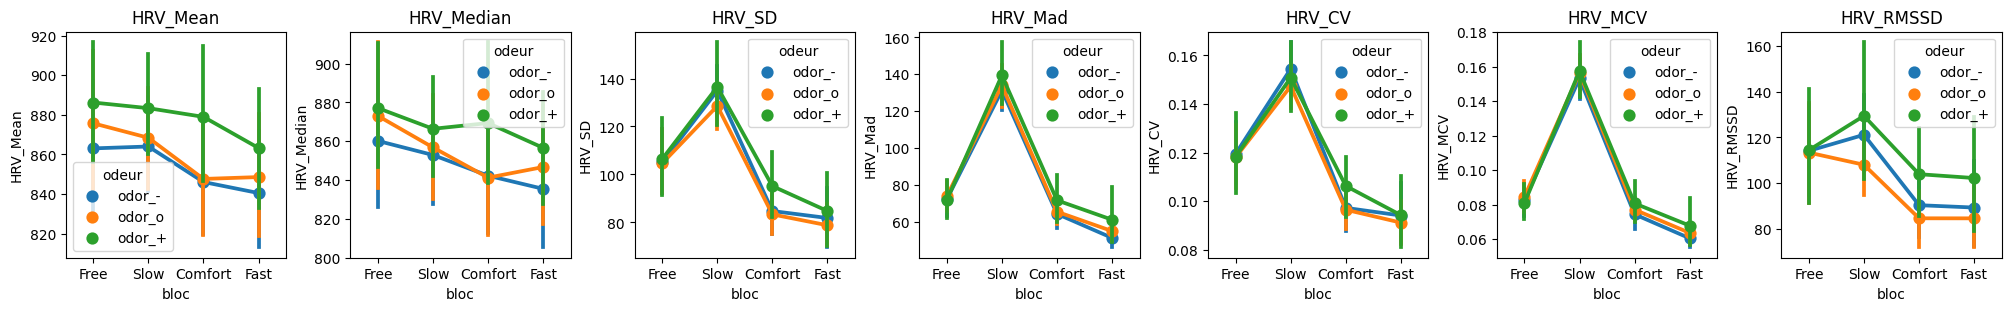

In [36]:
metrics = ['HRV_Mean','HRV_Median', 'HRV_SD','HRV_Mad', 'HRV_CV', 'HRV_MCV', 'HRV_RMSSD']

ncols = 7

fig, axs = plt.subplots(ncols=ncols , figsize = (20,3), constrained_layout = True)

for c, metric  in enumerate(metrics):
    ax = axs[c]
    sns.pointplot(data = hrv, x = 'bloc', y = metric, hue = 'odeur', ax=ax)
    ax.set_title(metric)

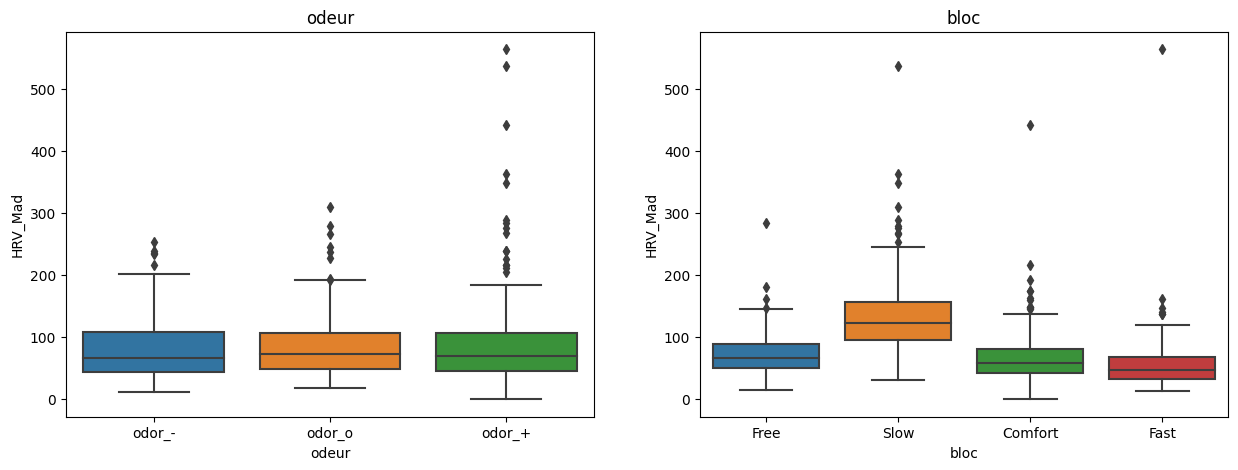

In [31]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
for c, predictor in enumerate(['odeur','bloc']):
    ax = axs[c]
    sns.boxplot(data=hrv, x = predictor, y = 'HRV_Mad', ax=ax)
    ax.set_title(predictor)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


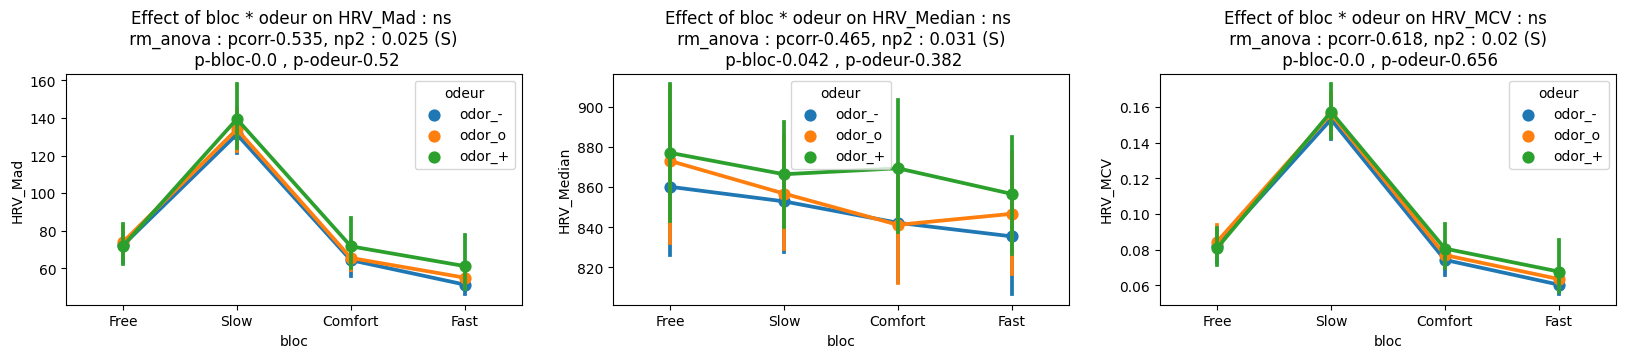

In [38]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,3))
for c, metric in enumerate(['HRV_Mad', 'HRV_Median','HRV_MCV']):
    ax = axs[c]
    gh.auto_stats(df=hrv, predictor = ['bloc','odeur'], outcome = metric, subject = 'participant', design = 'within', ax=ax)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


<AxesSubplot: title={'center': 'Effect of bloc * odeur on HRV_Asymmetry : ns \n rm_anova : pcorr-0.587, np2 : 0.02 (S) \n p-bloc-0.012 , p-odeur-0.251'}, xlabel='bloc', ylabel='HRV_Asymmetry'>

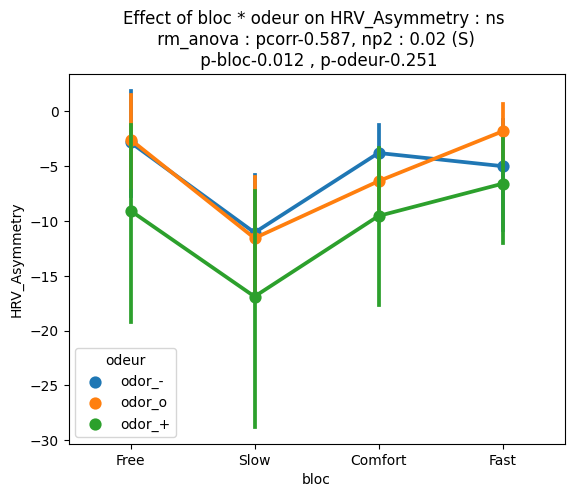

In [44]:
gh.auto_stats(df=hrv, predictor = ['bloc','odeur'], outcome = 'HRV_Asymmetry', subject = 'participant', design = 'within')

/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:379: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(pred

<AxesSubplot: title={'center': 'Effect of bloc on HRV_Mad : **** \n N = 25 subjects * 4 groups (*9 trial/group) \n friedman : p-0.0'}, xlabel='bloc', ylabel='HRV_Mad'>

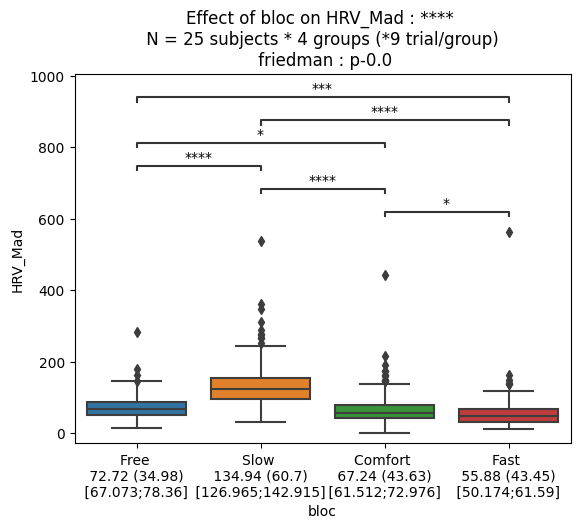

In [41]:
gh.auto_stats(df=hrv, predictor = 'bloc', outcome = 'HRV_Mad', subject = 'participant', design = 'within')